In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-customer-churn-a-binary-classification-ch/sample_submission.csv
/kaggle/input/predict-customer-churn-a-binary-classification-ch/train.csv
/kaggle/input/predict-customer-churn-a-binary-classification-ch/test.csv


**Introduction**

Welcome to this comprehensive guide on building a RandomForestClassifier machine learning model. This notebook is crafted with a beginner-friendly approach, providing detailed explanations for each step involved. The focus is on making concepts like data preparation, pipeline creation, and hyperparameter tuning with GridSearchCV accessible for less experienced readers. Hope you find this guide insightful and informative!

# 1) Data wrangling
This section covers everything from the initial examination of the data to preparing a preprocessed dataframe ready for input into the pipeline.

## Overview and Cleaning

A good way to begin tackling a classification problem is by visually examining the raw training data.

In [2]:
train = pd.read_csv('/kaggle/input/predict-customer-churn-a-binary-classification-ch/train.csv')
train

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15682442.0,Hsueh,506.0,Spain,Male,33.0,6.0,0.00,1.0,1.0,1.0,158845.49,0.0
1,1,15576676.0,Mazzi,651.0,Germany,Female,43.0,5.0,102773.20,1.0,0.0,1.0,85902.39,1.0
2,2,15668958.0,Walker,554.0,France,Female,37.0,6.0,0.00,2.0,1.0,1.0,139861.53,0.0
3,3,15783629.0,Yobachi,553.0,France,Female,31.0,1.0,0.00,2.0,1.0,1.0,26149.25,0.0
4,4,15795527.0,Chiu,646.0,France,Male,42.0,5.0,0.00,2.0,1.0,1.0,61761.77,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15661830.0,Ts'ui,597.0,France,Male,31.0,7.0,74988.59,1.0,0.0,0.0,92621.90,0.0
14996,14996,15578866.0,Ch'iu,682.0,Spain,Male,32.0,0.0,131394.56,1.0,0.0,1.0,119903.20,0.0
14997,14997,15689147.0,Chidiebele,535.0,Germany,Female,39.0,9.0,90971.85,1.0,0.0,1.0,74836.45,0.0
14998,14998,15807577.0,Niu,668.0,France,Female,47.0,2.0,0.00,2.0,0.0,1.0,171552.02,1.0


Before we go on with meaningful outlook on this dataset, some basic formal issues (missing values, duplicates), as well as primary data cleaning (redundant features exclusion), are sorted out.

**Redundant features**

Some features (columns) appear to be redundant, specifically **`'id'`**, **`'CustomerId'`**, and **`'Surname'`**. We will exclude them from the analysis, as there is no reason to believe that these arbitrary unique identifiers have any relevance to the target variable (note that we are working with cross-sectional data, where there is no inherent order among rows). A similar principle applies to **`'Surname'`**; it is likely best to exclude this arbitrary variable as well.

In [3]:
train.drop(columns=['id', 'CustomerId', 'Surname'], inplace=True)

**Basic formal issues**

In [4]:
print(f'Number of rows: {train.shape[0]}')
print(f'Number of columns: {train.shape[1]}')
print(f'Data types: {set(train.dtypes.values)}')
print(f'Missing values: {train.isnull().values.any()}')
print(f"Duplicates: {train.duplicated().sum()}")

Number of rows: 15000
Number of columns: 11
Data types: {dtype('float64'), dtype('O')}
Missing values: False
Duplicates: 0


The training data has no missing values or duplicates. However, if any NULL values (np.NAN) were present, we would need to decide how to address them. Common solutions include dropping rows with NULL values, removing entire columns if most of their values are NULL, or applying an imputation method. In the case of duplicates, when genuine duplicates are detected, only the first occurrence is typically kept.

**Meaningful outlook on training dataset**

Quick Reminder:
* **Nominal Variable**: Categorical data without an inherent order (e.g., color, gender).
* **Ordinal Variable**: Categorical data with a meaningful order or ranking (e.g., education level, satisfaction ratings).
* **Continuous Variable**: Numeric data that can take any value within a range and is measured on a continuous scale (e.g., height, temperature).

In [5]:
train.sample(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
12782,675.0,Germany,Male,48.0,0.0,105163.88,1.0,1.0,1.0,129964.94,0.0
11187,727.0,France,Female,35.0,2.0,96196.24,1.0,0.0,0.0,126013.58,0.0
7013,611.0,Spain,Male,34.0,5.0,0.00,1.0,1.0,0.0,46857.52,0.0


The immediate goals when examining the training data are, on one hand, to identify the types of features present (nominal, ordinal, or continuous) and, on the other hand, to examine the target distribution, particularly to assess whether it is imbalanced. As you might suspect, there are some reasons for this.  Let’s closely examine both aspects, starting with the issue of target distribution.

### Target distribution

In [6]:
train.Exited.value_counts(normalize=True)

Exited
0.0    0.7952
1.0    0.2048
Name: proportion, dtype: float64

The magnitude of this imbalance requires careful consideration. Ignoring a significant imbalance in the target variable can lead to a model biased toward the majority class, poor detection of the minority class, and misleading performance metrics.

One approach to address this imbalance is **oversampling**, such as generating synthetic examples for the minority class using SMOTE (Synthetic Minority Over-sampling Technique). This method can be effective when class instances are particularly rare. Alternatively, **undersampling** involves randomly removing instances from the majority class to balance the dataset. This approach works well when there is an abundance of data. In some cases, a combination of both strategies may be necessary. These approaches are known as **Resampling**.

However, we prefer a solution that retains all original data and avoids synthetic samples, given our sample size and target distribution. A suitable alternative is to use a scikit-learn classifier with a class_weight parameter. By setting `class_weight='balanced'`, the algorithm automatically adjusts class weights inversely proportional to class frequencies. This allows the model to handle the imbalance naturally while keeping things simple and effective.

### Features
Different types of features require different procedures (such as statistical tests, correlation coefficients, and preprocessing techniques, etc). To appropriately handle each variable, we first need to identify and categorize its type. Specifically, the variable can be classified as nominal, ordinal, or continuous. In some cases, the choice between treating a variable as ordinal or continuous may not be clear-cut. In such situations, relying on your intuition or experience, or conducting further investigation, is advisable.

In this notebook, we will adopt a **convention** to identify whether a feature is nominal, ordinal, or continuous based on its data type. Specifically, we will:
* Indicate **nominal** features with the **object** dtype,
* Indicate **ordinal** features with the **int** dtype,
* Indicate **continuous** features with the **float** dtype.

To facilitate this analysis, a dataframe named ***`features_info`*** is created. This dataframe provides basic metadata about our variables (columns), including data type 'dtype' and the number of unique values 'nunique'.

In [7]:
def columns_info(df):
    # features' basic metadata for a given df
    feature_info = {
        'feature': df.columns,
        'dtype': [df[col].dtype for col in df.columns],
        'nunique_vals': [df[col].nunique() for col in df.columns]}
    features_df = pd.DataFrame(feature_info)
    features_df.set_index('feature', inplace=True)
    features_df.sort_values(by='nunique_vals', ascending=False, inplace=True)
    return features_df

features_info = columns_info(train.drop(columns=['Exited']))
features_info

,dtype,nunique_vals
feature,,
EstimatedSalary,float64,6211
Balance,float64,3412
CreditScore,float64,372
Age,float64,55
Tenure,float64,11
NumOfProducts,float64,4
Geography,object,3
Gender,object,2
HasCrCard,float64,2


**Nominal features**

By definition, binary features are essentially nominal features. Another feature identified as nominal is **`'Geography'`**. 

In [8]:
for col in train.drop(columns='Exited').columns:
    if train[col].nunique() < 4:
        train[col] = train[col].astype(str)

**Ordinal features**

Features **`'NumOfProducts'`** and **`'Tenure'`** are inferred to be ordinal.

In [9]:
train.NumOfProducts = train.NumOfProducts.astype(int)
train.Tenure = train.Tenure.astype(int)

**Continous features**

The remaining features are assumed to be continuous, and these variables are indicated by the dtype 'float'.

In [10]:
features_info = columns_info(train.drop(columns=['Exited']))
features_info

,dtype,nunique_vals
feature,,
EstimatedSalary,float64,6211
Balance,float64,3412
CreditScore,float64,372
Age,float64,55
Tenure,int64,11
NumOfProducts,int64,4
Geography,object,3
Gender,object,2
HasCrCard,object,2


## Exploratory Data Analysis

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

To enhance exploratory data analysis (EDA) for categorical features, the function `categorical_eda()` is defined. This function generates two plots for a given categorical variable:
* **Countplot**: This plot shows the distribution of the variable and helps verify that each unique value has a sufficient frequency for meaningful statistical analysis.
* **Barplot**: This plot compares the mean of the target variable for each unique value of the feature. A red horizontal line represents the overall target mean. Values below this line indicate that the target is more frequently 0 for that particular unique value, while values above the line suggest that the target is more frequently 1.

In [12]:
def categorical_eda(feature):
    # generates figure facilitating EDA for a categorical feature 
    fig, axes = plt.subplots(1, 2, figsize=(10 * 0.8, 3 * 0.8))
    
    # countplot
    sns.countplot(data=train, x=feature, ax=axes[0])
    axes[0].set_title('Countplot', fontsize=11)
    axes[0].tick_params(axis='y', labelsize=9)
    axes[0].tick_params(axis='x', labelsize=9)
    axes[0].set_xlabel(xlabel=feature, fontsize=10)
    axes[0].set_ylabel(ylabel='Count', fontsize=10)

    # barplot
    sns.barplot(data=train, x=feature, y='Exited', ax=axes[1])
    axes[1].axhline(y=train.Exited.mean(), color='red', linestyle='-', label='global mean')
    axes[1].legend(loc='upper left', fontsize=8.2)
    axes[1].set_title('Target vs feature', fontsize=11)
    axes[1].tick_params(axis='y', labelsize=9)
    axes[1].tick_params(axis='x', labelsize=9)
    axes[1].set_xlabel(xlabel=feature, fontsize=10)
    axes[1].set_ylabel(ylabel='target_mean', fontsize=10)
    
    plt.tight_layout()
    plt.show()

### Nominal features
Here we apply `categorical_eda()` to each nominal variable one by one and inspect the results visually.

In [13]:
# nominal features are indicated by 'object' dtype
features_info[features_info.dtype=='object']

,dtype,nunique_vals
feature,,
Geography,object,3
Gender,object,2
HasCrCard,object,2
IsActiveMember,object,2


**`'Geography'`**

The countplot indicates no frequency issues with this variable, as each country is represented by more than 2,000 instances. The barplot suggests that German customers are more likely to churn.

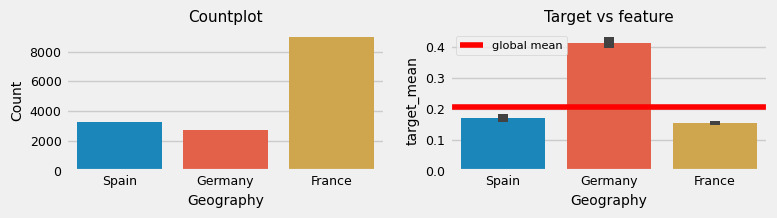

In [14]:
categorical_eda('Geography')

**`'Gender'`**

The training data suggests that females are more likely to churn than males.

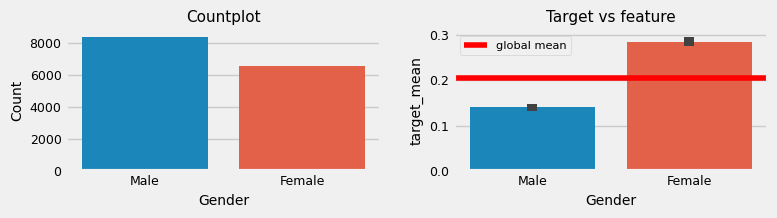

In [15]:
categorical_eda('Gender')

**`'HasCrCard'`**

At this point, there is nothing conclusive to say about this variable, except that it does not exhibit any frequency issues according to the plots.

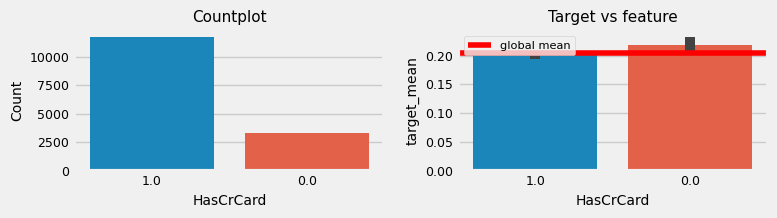

In [16]:
categorical_eda('HasCrCard')

**`'IsActiveMember'`**

Active members appear to churn less frequently.

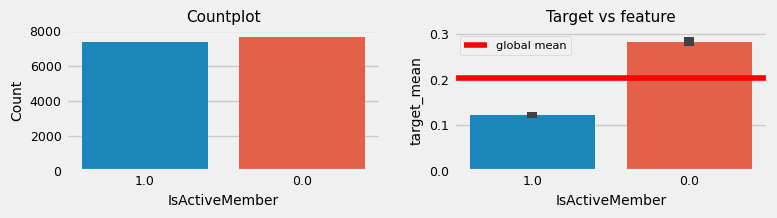

In [17]:
categorical_eda('IsActiveMember')

### Ordinal features

In [18]:
# ordinal features are indicated by 'int' dtype
features_info[features_info.dtype=='int']

,dtype,nunique_vals
feature,,
Tenure,int64,11
NumOfProducts,int64,4


Let's visually inspect both ordinal variables.

**`'Tenure'`**

In this case, the countplot suggests that there are at least a few hundred instances for each category, which is sufficient.

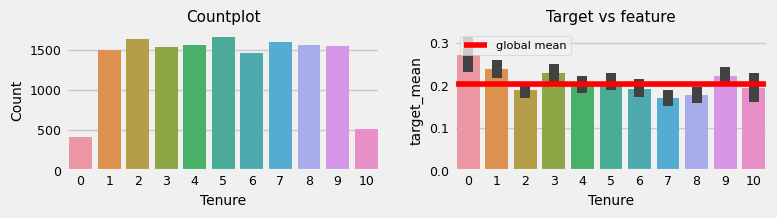

In [19]:
categorical_eda('Tenure')

**`'NumOfProducts'`**

It appears that once a customer has 3 or more of the bank's products, they are almost certain to churn. However, let's closely examine the **`value_counts()`** of this feature, as there may be a frequency-related issue here.

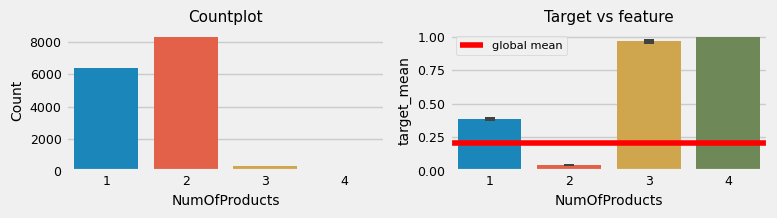

In [20]:
categorical_eda('NumOfProducts')

In [21]:
train.NumOfProducts.value_counts()

NumOfProducts
2    8339
1    6388
3     256
4      17
Name: count, dtype: int64

In [22]:
# this is over-excessive and also a little sad to see
train[train.NumOfProducts==4]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
264,544.0,Spain,Female,36.0,5,0.00,4,1.0,0.0,110748.88,1.0
296,478.0,France,Male,37.0,1,0.00,4,1.0,0.0,28750.67,1.0
1062,684.0,Germany,Female,37.0,1,144974.55,4,1.0,1.0,182865.09,1.0
1185,652.0,France,Female,56.0,3,0.00,4,0.0,1.0,171070.58,1.0
1417,633.0,Germany,Male,40.0,5,96763.89,4,1.0,0.0,86424.57,1.0
4842,539.0,Spain,Male,55.0,1,0.00,4,1.0,0.0,167984.72,1.0
7578,509.0,Spain,Female,55.0,9,123815.86,4,1.0,0.0,167984.72,1.0
8161,537.0,Spain,Female,47.0,1,0.00,4,1.0,0.0,45419.09,1.0
10530,558.0,France,Female,42.0,8,0.00,4,0.0,1.0,140929.98,1.0
11320,607.0,France,Female,43.0,6,0.00,4,1.0,0.0,107615.43,1.0


The exact numbers indicated by **`value_counts()`** for this variable could ideally be more balanced, but it’s clear that this feature has significant predictive power worth incorporating into our model. The barplot suggests that having 3 or 4 products is similar in terms of churn probability. Therefor, we will merge these two categories and treat them as a single one, representing **`'NumOfProducts'>= 3`**.

In [23]:
train['NumOfProducts'] = train['NumOfProducts'].replace(4, 3)

### Continous features
To facilitate the exploratory data analysis (EDA) of continuous features, function `continous_eda()` is created. This function generates two plots for a given variable:
* **histogram with KDE** (feature distribution)
* **violinplot** (target impact on feature distribution)

In [24]:
import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def continous_eda(feature):
    # generates figure facilitating EDA for a continous features 
    fig, axes = plt.subplots(1, 2, figsize=(10 * 0.8, 3))
    
    # histogram with KDE 
    sns.histplot(data=train, x=feature, kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {feature}', fontsize=12)
    axes[0].set_xlabel(feature, fontsize=10)
    axes[0].set_ylabel('Count', fontsize=10)
    axes[0].tick_params(axis='x', labelsize=10)
    axes[0].tick_params(axis='y', labelsize=10)
    
    # violin plot 
    sns.violinplot(x='Exited', y=feature, data=train, ax=axes[1])
    axes[1].set_title(f'{feature} vs. Target (Exited)', fontsize=12)
    axes[1].set_xlabel('Exited', fontsize=10)
    axes[1].set_ylabel(feature, fontsize=10)
    axes[1].tick_params(axis='x', labelsize=10)
    axes[1].tick_params(axis='y', labelsize=10)
    
    plt.tight_layout()
    plt.show()

In [25]:
# continous features are indicated by 'float' dtype
features_info[features_info.dtype=='float']

,dtype,nunique_vals
feature,,
EstimatedSalary,float64,6211
Balance,float64,3412
CreditScore,float64,372
Age,float64,55


Quick Reminder:

Descriptive statistics provide a summary of the central tendency, dispersion, and range of the numeric data.
* **Count**: The number of non-null entries.
* **Mean**: The average value of the column.
* **Standard Deviation (std)**: The average deviation from the mean for a data point.
* **Minimum (min)**: The smallest value in the column.
* **25th Percentile (25%)**: The value below which 25% of the data falls.
* **Median (50%)**: The middle value of the column, separating the data into two halves.
* **75th Percentile (75%)**: The value below which 75% of the data falls.
* **Maximum (max)**: The largest value in the column.

**`'EstimatedSalary'`**

A troublemaker variable; applying `continous_eda()` produces an unreadable mess.

In [26]:
# descriptive statistics
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train['EstimatedSalary'].to_frame().describe()

,EstimatedSalary
count,15000.00
mean,118914.46
std,134968.90
min,11.58
25%,83022.92
50%,122949.71
75%,156914.44
max,15677431.85


Descriptive statistics for this feature indicate a high degree of variability with a wide range and the presence of extreme outliers. Such extreme values can skew statistical analyses and models. To mitigate their impact, it may be beneficial to address these outliers using robust statistical methods or by applying transformations or binning techniques.

In our case, the **RandomForestClassifier** is quite robust to outliers because it uses an ensemble of decision trees, which are less sensitive to extreme values. Each tree in the forest is trained on a random subset of the data, and the final decision is based on the majority vote from all trees, reducing the influence of outliers on the overall model.

Let's investigate further **`'EstimatedSalary'`** and check whether a linear relationship is present between this feature and the target variable. The **`Point Biserial Correlation`** is an appriopriate coefficient for a continous feature and a binary target.

In [27]:
from scipy.stats import pointbiserialr

corr, p_value = pointbiserialr(train['EstimatedSalary'], train['Exited'])
print(f"Point Biserial Correlation between EstimatedSalary and Target: {corr:.2f}")
print(f"p_value: {p_value:.2f}")

Point Biserial Correlation between EstimatedSalary and Target: 0.01
p_value: 0.48


A coefficient close to 0 (e.g., 0.01) and a p-value of 0.48, which is much higher than the significance level of 0.05, lead us to conclude that there is no linear relationship between the feature and the target.

Let's emphasize the fact that the **`Point Biserial Correlation`** specifically detects linear relationships. If the relationship between a feature and the target is non-linear, the correlation coefficient might be close to zero, even if the feature is significant for classification. The **`Mann-Whitney U test`** is non-parametric (it does not assume any specific distribution of the data) and does not rely on linearity, so it is suitable for detecting non-linear relationships between a feature and a binary target variable and therefore will be conducted down the line. 

Since binning a continuous variable can help capture potential non-linear relationships with a binary target, let's create an additional feature **`'EstimatedSalary_binned'`** derived from the **`'EstimatedSalary'`** variable and include it in the analysis. Although this might introduce some collinearity, the **RandomForestClassifier** is quite robust to such issues (more details on this are provided in the next subsection, titled 'Collinearity'). Adding this derived feature could help the model account for non-linearity.

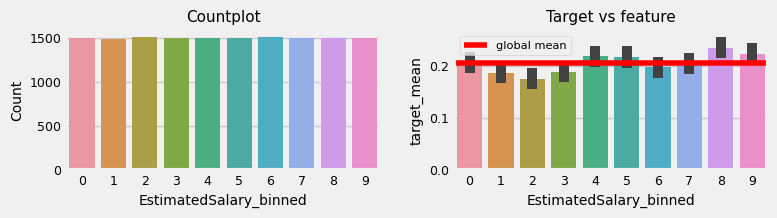

In [28]:
from sklearn.preprocessing import KBinsDiscretizer

kbin_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
train['EstimatedSalary_binned'] = kbin_discretizer.fit_transform(train[['EstimatedSalary']])
# this is an ordinal variable
train['EstimatedSalary_binned'] = train['EstimatedSalary_binned'].astype(int)

categorical_eda('EstimatedSalary_binned')

Here is the rationale for why using **`KBinsDiscretizer`** with the quantile strategy can help capture potential non-linear relationships:
* **Non-linear Relationships**: Continuous variables can have complex, non-linear relationships with the target variable that are not easily captured by linear models. By discretizing the continuous variable into bins, you essentially create a new categorical variable where each bin represents a range of values from the original variable.
* **Quantile Strategy**: When using the quantile strategy in **KBinsDiscretizer**, the continuous variable is divided into bins such that each bin has roughly the same number of observations. This can help in revealing patterns or associations that might be missed if the variable were treated as continuous.
* **Ordinal Encoding**: When these bins are encoded as ordinal values, you preserve the order of the bins, which might help models like decision trees or even some linear models with interaction terms capture the non-linear relationship more effectively.

Okay, let’s now move on to the next continuous feature, **`'Balance'`**.

**`'Balance'`**


At least half of the values for this variable are actually zeros. One possible explanation could be a significant number of "ghost accounts". It might be beneficial to create a binary variable **`'HasBalance'`** indicating whether the balance is zero, as this could help the model capture patterns related to these "ghost accounts".

In [29]:
# descriptive statistics
train['Balance'].to_frame().describe()

,Balance
count,15000.00
mean,42689.54
std,59635.26
min,0.00
25%,0.00
50%,0.00
75%,109356.43
max,187530.66


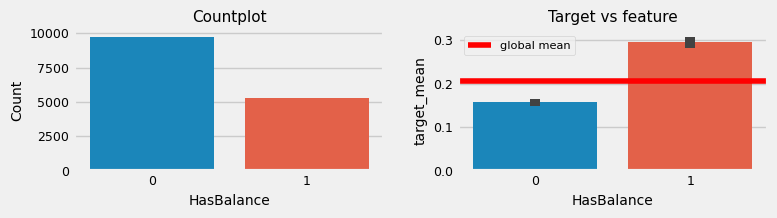

In [30]:
train['HasBalance'] = (train['Balance'] > 0).astype(int)
# this is a nominal variable
train['HasBalance'] = train['HasBalance'].astype(str)

categorical_eda('HasBalance')

It seems that binarization might add some explanatory power to the model, as indicated by the barplot. Let's explore the **`'Balance'`** feature further, specifically examining whether a linear relationship exists between this feature and the target variable. For this case, we will focus only on the non-zero instances of the **`'Balance'`** feature when calculating the Point Biserial correlation coefficient.

In [31]:
corr, p_value = pointbiserialr(train[train['Balance']>0].Balance, train[train['Balance']>0].Exited)
print(f"Point Biserial Correlation between Balance and Target: {corr:.2f}")
print(f"p_value: {p_value:.2f}")

Point Biserial Correlation between Balance and Target: 0.01
p_value: 0.40


A coefficient close to 0 (e.g., 0.01) and a p-value of 0.40, which is much higher than the significance level of 0.05, lead us to conclude that there is no linear relationship between the **`'Balance'`** feature and the target. However, this does not exclude the possibility of a non-linear dependency. As with the **`'EstimatedSalary'`** feature, we will also verify potential non-linear relationships using the **`Mann-Whitney U test`** (while statistical testing). 

Aside from the numerous zeros, the **`'Balance'`** variable does not appear to have any other issues. Below, a violin plot for non-zero balances is provided to give insight into how the binary target impacts the distribution of the feature.

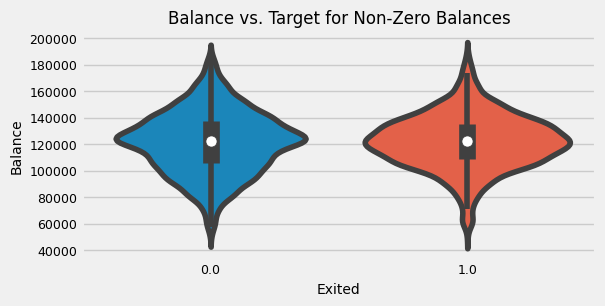

In [32]:
plt.figure(figsize=(5.9, 2.8))

plt.title('Balance vs. Target for Non-Zero Balances', fontsize=12)
ax = sns.violinplot(x='Exited', y='Balance', data=train[train['Balance'] > 0])
ax.set_xlabel('Exited', fontsize=10)
ax.set_ylabel('Balance', fontsize=10)
ax.tick_params(axis='x', labelsize=9)  
ax.tick_params(axis='y', labelsize=9) 

plt.show()

**`'CreditScore'`**

This continous feature behaves kindly.

In [33]:
train['CreditScore'].to_frame().describe()

,CreditScore
count,15000.00
mean,657.78
std,72.98
min,431.00
25%,600.00
50%,661.00
75%,709.00
max,850.00


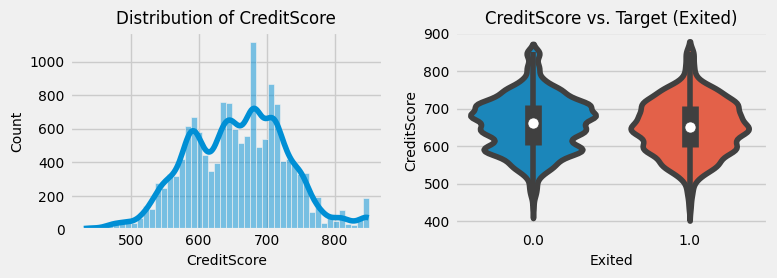

In [34]:
continous_eda('CreditScore')

In [35]:
corr, p_value = pointbiserialr(train['CreditScore'], train['Exited'])
print(f"Point Biserial Correlation between CreditScore and Target: {corr:.2f}")
print(f"p_value: {p_value:.2f}")

Point Biserial Correlation between CreditScore and Target: -0.04
p_value: 0.00


Above results means that there is a statistically significant linear relationship between **`'CreditScore'`** and the binary target, but the strength of this relationship is minimal.

**`'Age'`**

This continous feature behaves very kindly.

In [36]:
train['Age'].to_frame().describe()

,Age
count,15000.00
mean,37.81
std,8.24
min,18.00
25%,32.00
50%,37.00
75%,42.00
max,74.00


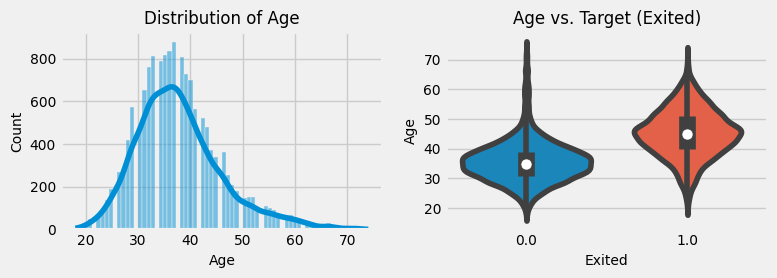

In [37]:
continous_eda('Age')

In [38]:
corr, p_value = pointbiserialr(train['Age'], train['Exited'])
print(f"Point Biserial Correlation between Age and Target: {corr:.2f}")
print(f"p_value: {p_value:.2f}")

Point Biserial Correlation between Age and Target: 0.46
p_value: 0.00


The results indicate that there is a statistically significant moderate positive linear relationship between **`'Age'`** and the target variable.

### Colinearity
Let's examine linear correlations by creating a heatmap that includes all numeric features and the binary target variable. Note that the Pearson correlation coefficient is used in this heatmap, which will provide us with only a rough, general sense of collinearity among the variables at most.

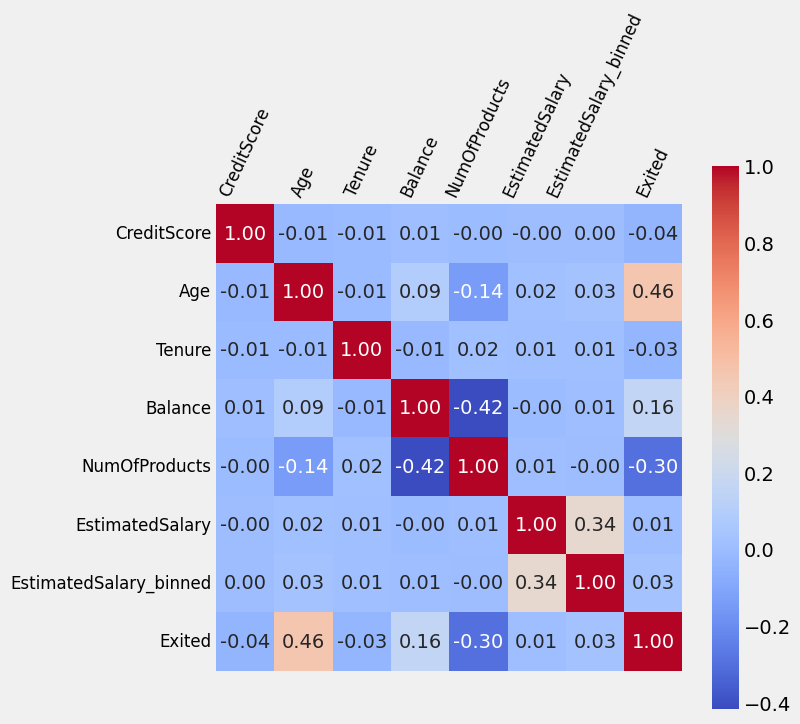

In [39]:
# reordering columns
numeric_cols = train.select_dtypes(exclude='object').columns
cols_with_exited_poped = [col for col in numeric_cols if col != 'Exited'] + ['Exited']

# Pearson coeff heatmap
plt.figure(figsize=(6.7, 6.7))

ax = sns.heatmap(train[cols_with_exited_poped].corr(), 
                 annot=True,
                 fmt='.2f',
                 square=True, 
                 cmap='coolwarm')

ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_tick_params(labelsize=12, rotation=65)
ax.yaxis.set_tick_params(labelsize=12)

plt.show()

Collinearity among our features does not appear to be a major issue. If it were, methods like **`PCA`** could be applied to address it. 

Moreover, **`RandomForestClassifier`** is generally robust to collinearity among features. Here's why:
* **Decision Trees Structure**: Random forests are composed of multiple decision trees, and each tree is built using a random subset of the features (due to feature bagging). This means that not all trees will include the collinear features, reducing the impact of collinearity on the model as a whole.
* **Feature Importance**: In random forests, if two or more features are highly correlated (collinear), the model might distribute the importance among them. However, because each tree in the forest can select different subsets of features, the overall importance of these correlated features is diluted across the forest.
* **Model Averaging**: Since the final prediction of a random forest is based on the average or majority vote of all the trees, the effect of collinearity is further minimized compared to models like linear regression, where collinearity can directly affect the coefficients and lead to instability.

## Train / Test Split
Train/test splitting is typically done before statistical testing or model training to prevent data leakage, which occurs when information from the test set unintentionally influences the model during training.

In [40]:
from sklearn.model_selection import train_test_split

y = train.Exited
X = train.drop('Exited', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=train.Exited)

Due to the sufficiently large size of the ***`train`*** dataframe, the distribution of the target variable **`'Exited'`** in ***`y_test`*** is expected to closely resemble that in ***`train.Exited`***. This expectation is supported by the law of large numbers, which suggests that larger samples tend to reflect the true population distribution more accurately. However, to ensure that the distribution of ***`train.Exited`*** is preserved, we explicitly set the **`stratify`** parameter accordingly. This parameter is particularly useful when working with smaller samples, as it helps maintain the target distribution across both, ***`y_train`*** and ***`y_test`***.

### Training data summary

In [41]:
# formal issues
print(f'Number of rows: {X_train.shape[0]}')
print(f'Number of columns: {X_train.shape[1]}')
print(f'Data types: {set(X_train.dtypes.values)}')

Number of rows: 12000
Number of columns: 12
Data types: {dtype('float64'), dtype('O'), dtype('int64')}


In [42]:
X_train.sample(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,EstimatedSalary_binned,HasBalance
3775,691.00,France,Male,32.00,2,0.00,2,1.0,1.0,124592.84,5,0
12024,567.00,France,Female,24.00,5,0.00,2,0.0,0.0,184842.21,9,0
7498,516.00,France,Male,39.00,1,0.00,2,1.0,1.0,71175.94,1,0
2679,558.00,France,Female,48.00,1,135096.05,3,1.0,0.0,57572.38,1,1
6232,595.00,France,Male,25.00,3,0.00,2,1.0,0.0,48924.73,0,0


In [43]:
columns_info(X_train)

,dtype,nunique_vals
feature,,
EstimatedSalary,float64,5482
Balance,float64,2909
CreditScore,float64,371
Age,float64,55
Tenure,int64,11
EstimatedSalary_binned,int64,10
NumOfProducts,int64,3
Geography,object,3
Gender,object,2


## Statististical Significance Testing

**Numeric features**

Since the target is binary, we can split the data into two groups based on the target variable and use the **`Mann-Whitney U test`** to determine if the distributions of our continuous or ordinal features differ significantly between these two groups. The **`Mann-Whitney U test`** is a non-parametric test (assumption of normality is not necessary) appropriate for significance testing here both, continuous and ordinal variables. 

In [44]:
for feature in X_train.select_dtypes(exclude='object').columns:
    print(feature)

CreditScore
Age
Tenure
Balance
NumOfProducts
EstimatedSalary
EstimatedSalary_binned


In [45]:
from scipy.stats import mannwhitneyu

df_train = pd.concat([X_train, y_train], axis=1)

for feature in X_train.select_dtypes(exclude='object').columns:
    group_0 = df_train[df_train['Exited']==0][feature]
    group_1 = df_train[df_train['Exited']==1][feature]
    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
    if p < 0.05:
        print('{} is statistically significant.'.format(feature))

CreditScore is statistically significant.
Age is statistically significant.
Tenure is statistically significant.
Balance is statistically significant.
NumOfProducts is statistically significant.
EstimatedSalary is statistically significant.
EstimatedSalary_binned is statistically significant.


**Nominal features**

The **`chi2_contingency test`** is used to determine if there is a significant association between two categorical variables. It assesses whether the observed frequencies in each category are significantly different from the expected frequencies under the assumption of independence. This test is also non-parametric, meaning it does not assume any specific distribution for the data.

In [46]:
from scipy.stats import chi2_contingency

for feature in X_train.select_dtypes(include='object').columns:
    contingency_table = pd.crosstab(df_train[feature], df_train['Exited'])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    if p < 0.05:
        print('{} is statistically significant.'.format(feature))

Geography is statistically significant.
Gender is statistically significant.
HasCrCard is statistically significant.
IsActiveMember is statistically significant.
HasBalance is statistically significant.


## Preprocessing
The **`RandomForestClassifier`** does not require the application of a **StandardScaler**, **MinMaxScaler**, or other scaling methods to numeric features, which is more the exception than the rule, as most other algorithms are sensitive to feature scaling. However, nominal features need to be converted to numeric format, so **One-Hot Encoding** should be applied to these variables. **One-hot Encoding** converts categorical variables into binary vectors, where each unique category is represented by a separate binary feature, with a value of 1 indicating the presence of that category and 0 indicating its absence.

In [47]:
from sklearn.compose import make_column_transformer

The **`make_column_transformer`** function from **`sklearn.compose`** is a powerful tool for preprocessing data in machine learning pipelines. It allows you to apply different preprocessing steps to different columns in your dataset. Two main features are:
* **Column-Specific Transformations**: You can specify different preprocessing steps for different columns based on their data types. For example, you might want to apply one-hot encoding to categorical columns and scaling to numerical columns.
* **Seamless Integration**: make_column_transformer integrates well with Pipeline from sklearn.pipeline, making it easy to include preprocessing steps as part of a complete machine learning workflow.

Let's have a look at preprocessed data:

In [48]:
from sklearn.preprocessing import OneHotEncoder

prep = make_column_transformer((OneHotEncoder(drop='first'), X_train.select_dtypes(include='object').columns), remainder='passthrough')

X_train_transformed = prep.fit_transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed)
X_train_transformed

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00,0.00,0.00,1.00,1.00,0.00,649.00,41.00,2.00,0.00,2.00,38691.34,0.00
1,0.00,1.00,1.00,1.00,0.00,0.00,724.00,46.00,8.00,0.00,1.00,180712.52,9.00
2,0.00,0.00,1.00,1.00,1.00,1.00,697.00,31.00,2.00,101707.70,1.00,153566.97,7.00
3,0.00,1.00,1.00,1.00,0.00,0.00,629.00,37.00,5.00,0.00,2.00,167984.72,8.00
4,0.00,0.00,0.00,1.00,0.00,0.00,637.00,35.00,7.00,0.00,1.00,121408.56,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.00,0.00,1.00,1.00,0.00,0.00,634.00,33.00,3.00,0.00,2.00,170829.87,8.00
11996,0.00,1.00,0.00,1.00,0.00,1.00,790.00,40.00,2.00,87779.83,2.00,131736.23,5.00
11997,1.00,0.00,0.00,1.00,1.00,1.00,662.00,27.00,2.00,93833.86,2.00,54871.02,0.00
11998,0.00,0.00,0.00,1.00,1.00,0.00,607.00,42.00,1.00,0.00,2.00,159718.15,7.00


# 2) Model Training
All essential components are brought together in this section to perform machine learning with **`RandomForestClassifier`**.

Quick Reminder:


**`K-fold cross-validation (CV)`** is a technique used to evaluate a machine learning model's performance by making the most efficient use of the available data. Here's how it works:
1. **Data Splitting**: The dataset is randomly divided into K equal-sized subsets or "folds".
2. **Training and Validation**: The model is trained on K-1 folds and tested on the remaining fold. This process is repeated K times, with each fold serving as the test set exactly once.
3. **Performance Averaging**: The results from all K iterations are averaged to give a more reliable estimate of the model's performance.

**Pipeline**

To proceed with training, we need to use the already defined **prep** object, import **`RandomForestClassifier`**, and instantiate a pipeline with `make_pipeline()` to chain multiple steps into a single workflow. Note that `class_weight='balanced'` is specified to mitigate the impact of an imbalanced target distribution.

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(prep, RandomForestClassifier(class_weight='balanced'))

**Hyperparameters tuning**

Hyperparameters of a **`RandomForestClassifier`** include settings such as:
* **n_estimators**: This controls the number of trees in the forest, which impacts the model's performance and stability.
* **criterion**: This defines the function used to measure the quality of a split, such as 'gini' or 'entropy'.
* **min_samples_split**: This determines the minimum number of samples required to split an internal node, affecting the model's complexity and generalization.
* **min_samples_leaf**: This specifies the minimum number of samples required to be at a leaf node, helping to prevent overfitting by ensuring that branches contain enough data.

The exact values of these hyperparameters, which control the behavior and performance of the model, are unknown and need to be determined. **`GridSearchCV`** is an extremely useful tool for this task, as it exhaustively searches a pre-specified hyperparameter space by evaluating all possible combinations. Each combination is assessed using **`10-fold cross-validation`**, ensuring that the optimal set of hyperparameters is both robust and reliable. Here is our pre-defined `hyperparameter space` to be researched in this study:

In [50]:
hyperspace = {
        'randomforestclassifier__n_estimators':[85, 120, 150],
        'randomforestclassifier__criterion':['gini', 'entropy', 'log_loss'],
        'randomforestclassifier__min_samples_split':[2, 4, 8],
        'randomforestclassifier__min_samples_leaf':[2, 4, 8]
    }

**Training**

Now, we’re ready to bring everything together to build and execute our **`RandomForestClassifier`** ML model. The process seamlessly integrates all the steps we’ve prepared—`prep`, the machine learning `pipeline`, and hyperparameter tuning with **`GridSearchCV`**. Note that even with all this complexity, we still rely on the same familiar 'fit' and 'predict' API that is standard across all scikit-learn models.

In [51]:
%%time
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(pipeline, hyperspace, cv=10, scoring='roc_auc')
model.fit(X_train, y_train)

CPU times: user 20min, sys: 1.63 s, total: 20min 2s
Wall time: 20min 2s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         Index(['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'HasBalance'], dtype='object'))])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced'))]),
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy',
                                                               'log_loss'],
                         'randomforestclassifier__min_samples_leaf': [2, 4, 8],
                         'randomforestclassifier__min_samples_split': [2, 4, 8],
                         'randomforestclassifier__n_estimators': [85, 120,
                                                                  150]},
             scoring='roc_auc')

## Best model (specification)
Optimal hyperparams indicated by **`GridSearchCV`**. 

In [52]:
model.best_params_

{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 150}

# 3) Model Evaluation
A good starting point for evaluating a classifier is the confusion matrix. **The confusion matrix** provides a detailed breakdown of the classifier's performance across all classes. It also serves as a basis for deeper analysis and subsequent metrics, like:
* **Accuracy**: Provides a general overview of the model’s performance but does not indicate how well each individual class is performing.
* **Sensitivity**: Measures the proportion of actual positive cases correctly identified by the model. It reflects the model’s ability to detect positive instances, also known as the true positive rate.
* **Specificity**: Measures the proportion of actual negative cases correctly identified by the model. It reflects the model’s ability to identify negative instances, also known as the true negative rate.

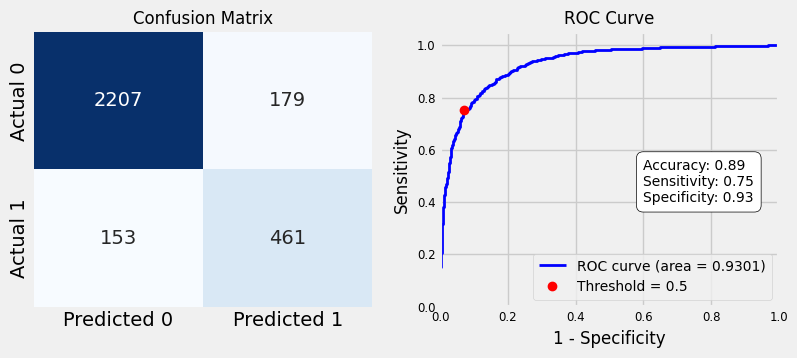

In [53]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Compute confusion matrix
cm = confusion_matrix(y_test, model.predict(X_test))

# Compute ROC curve and AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Compute accuracy, sensitivity and specificity
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
default_threshold_index = np.where(thresholds > 0.5)[0][-1]
sensitivity = tpr[default_threshold_index]
specificity = 1 - fpr[default_threshold_index]

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(8.2, 3.8))

# Confusion Matrix subplot
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'], 
            cbar=False, 
            ax=axes[0])

axes[0].set_title('Confusion Matrix', fontsize=12)


# ROC Curve subplot
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
axes[1].legend(loc="lower right", fontsize=8)
axes[1].text(0.6, 0.4, f'Accuracy: {accuracy:.2f}\nSensitivity: {sensitivity:.2f}\nSpecificity: {specificity:.2f}', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'), 
             fontsize=10)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('1 - Specificity', fontsize=12)
axes[1].set_ylabel('Sensitivity', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=8.5)
axes[1].set_title('ROC Curve', fontsize=12)
axes[1].plot(fpr[default_threshold_index], tpr[default_threshold_index], 'ro', label='Threshold = 0.5')
axes[1].legend(loc="lower right", fontsize=10)

plt.tight_layout()
plt.show()

**ROC Curve**

The **`ROC Curve`** (Receiver Operating Characteristic curve) is essentially a tool for visualizing **`trade-off`** between sensitivity and specificity. The trade-off between sensitivity and specificity often arises because adjusting the classification threshold can improve one metric at the expense of the other. The threshold is a decision point that determines how the model’s predicted probabilities are converted into class labels. For example, if the threshold is set to 0.5, the model will classify an instance as positive if its predicted probability is greater than or equal to 0.5. **`Threshold Tuning`** allows you to find the optimal balance between sensitivity and specificity based on your specific needs. For example, in medical diagnostics, you might prefer a higher sensitivity to ensure that most of the patients with a condition are identified, even if it means that some healthy patients are incorrectly classified as having the condition (lower specificity). Conversely, in fraud detection, you might prefer higher specificity to avoid falsely flagging legitimate transactions as fraudulent, even if it means missing some fraudulent cases (lower sensitivity).

**AUC (submission metric)**

**`AUC (Area Under the ROC Curve)`** is a threshold-agnostic metric that evaluates a classifier's performance across all possible threshold values, providing a synthetic measure of its overall ability to distinguish between classes.

## Best model refit
It is strongly recommended to refit the best model using the entire training dataset before making final predictions. This ensures that the model benefits from all available training data.

In [54]:
print(f'Number of rows X_train: {X_train.shape[0]}')
print(f'Number of rows train: {train.shape[0]}')

Number of rows X_train: 12000
Number of rows train: 15000


In [55]:
# Classifier instantiation with best params
classifier = RandomForestClassifier(n_estimators = model.best_params_['randomforestclassifier__n_estimators'],
                                    criterion = model.best_params_['randomforestclassifier__criterion'],
                                    min_samples_split = model.best_params_['randomforestclassifier__min_samples_split'], 
                                    min_samples_leaf = model.best_params_['randomforestclassifier__min_samples_leaf'],
                                    class_weight = 'balanced'
                                   )

In [56]:
%%time
forest = make_pipeline(prep, classifier)
forest.fit(train.drop(columns=['Exited']), train.Exited)

CPU times: user 2.61 s, sys: 18 ms, total: 2.63 s
Wall time: 2.63 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'HasBalance'], dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', min_samples_leaf=4,
                                        n_estimators=150))])

# 4) Submisson

In [57]:
def data_cleaner(raw_data):
    # cleans data for 'forest' pipeline
    raw_data.set_index('id', inplace=True)
    raw_data.drop(columns=['CustomerId', 'Surname'], inplace=True)
    raw_data['NumOfProducts'] = raw_data['NumOfProducts'].replace(4, 3)
    raw_data['EstimatedSalary_binned'] = kbin_discretizer.fit_transform(raw_data[['EstimatedSalary']])
    raw_data['HasBalance'] = (raw_data['Balance'] > 0).astype(int)
    raw_data['Tenure'] = raw_data['Tenure'].astype(int)
    raw_data['EstimatedSalary_binned'] = raw_data['EstimatedSalary_binned'].astype(int)
    raw_data['NumOfProducts'] = raw_data['NumOfProducts'].astype(int)
    raw_data['HasCrCard'] = raw_data['HasCrCard'].astype(str)
    raw_data['IsActiveMember'] = raw_data['IsActiveMember'].astype(str)
    raw_data['HasBalance'] = raw_data['HasBalance'].astype(str)
    return raw_data

In [58]:
test = pd.read_csv('/kaggle/input/predict-customer-churn-a-binary-classification-ch/test.csv')
y_hat = forest.predict_proba(data_cleaner(test))[:, 1]
submission = pd.DataFrame(test.reset_index().id).assign(Exited=y_hat)
submission

,id,Exited
0,15000,0.71
1,15001,0.13
2,15002,0.26
3,15003,0.03
4,15004,0.03
...,...,...
9995,24995,0.08
9996,24996,0.56
9997,24997,0.01
9998,24998,0.06


I hope you found this notebook helpful in understanding the workflow and concepts covered. Feel free to explore further and experiment with the code. `Thank you` for your time and interest!